# Homework 5: Photometric reverberation mapping

<span style="color:red">**Deadline:** </span> 08.05.2023.

# Task 1

**Goal:**

- Understand the photometric reverberation mapping method and its limitations. 
- Introduction to the tools for simulating AGN light curves and performing photoRM.

<span style="color:blue">**a)**</span> Familiarize yourself with photRM module (read the docs located in photRM.py). Using the `lc_two_bands` function from the `photRM` module, construct **three pairs** of continuum and emission line light curves of length 5000 days. This is a hypothetical scenario where we generate pairs of light curves as if they are observed in two broadband filters:

   - one covering only continuum emission (we will name it *x-band*)
   - second covering emission line and the underlying continuum (we will name it *y-band*)

Make sure that the light curve pairs are simulated for the artificial AGN objects at z = 0.1 having luminosity (log L): 43, 44, and 45, respectively. The emission line contribution to the total integrated flux should be 25% and the continuum contribution 75% in all cases. Plot the first 1000 days of the light curves and compare the properties (printed when you run `lc_two_bands`) of these three simulated AGN objects. How would you explain the correlation between AGN luminosity and broad line region dimensions (i.e. time-lag)? Cut the light curve length to 1000 points and save them for later use.

<span style="color:blue">**b)**</span> Using the photometric reverberation mapping method and the `pyzdcf` module, estimate the time-lag (broad line region radius) for these three light curve pairs. You can use the default values for keyword arguments in the function. How do the time-lag estimates compare to the values reported by `lc_two_bands`? You can estimate the time-lag using the `photRM.peak_finder` or (optionally) you can compile a Fortran code [PLIKE](https://www.weizmann.ac.il/particle/tal/research-activities/software) to obtain more accurate results and errors. Similarly display the results as in Astro Data Lab notebook.

>To install pyzdcf:
>
>   `pip install pyzdcf`
>    
>or you can run this notebook in Astro Data Lab where `pyzdcf` is already installed.

> To run PLIKE:
>
> - download the source code [here](https://webhome.weizmann.ac.il/home/tal/zdcf/plike_v4.0.f90)
> - if you don't have a fortran compiler, I suggest you install `gfortran` on your system
> - navigate to the folder containing the downloaded file
> - from there, run the following commands in the terminal:  
> `gfortran -o plike source_code_filename`  
> `./plike`

<span style="color:blue">**c)**</span> Now, to reflect a real-world scenario, let's make one of these three pairs of simulated light curves gappier (e.g., the one with log(L) = 44). Alter the light curves so they have the following cadences:

- one observation every 5 days
- one months of observations every day, then one month pause. Repeat the pattern.
- three month of observations every day, followed by six months of observations with a frequency of once per month and then a gap of three months. Repeat the pattern.

Estimate the time-lag from these three pairs of light curves. Write your conclusions regarding the accuracy of time-lag retrieval for different observing strategies you implemented. The light curves should not be longer than 1000 days.

In [1]:
# Imports:

# Standard libs
import os

# 3rd party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import find_peaks
from speclite import filters
import astropy.units as u

# Local libs
from add_asym import add_asym
import photRM as rm
import matplotlib.ticker as plticker

# A
# Generate first LC.
# T=0.1, log(L)=43

In [2]:
x_band,y_band,line_res=rm.lc_two_bands(T=5000.0, osc=True, A=0.14, noise=0.00005, z=0.1, method='Kelly1',
                 lag='random', lum=43, wl=0.2, wc=0.8, plot_kernel=False)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 43.00
MBH = 3.14e+06 M_sun
tau_DRW = 17.31 days
sigma_DRW = 0.05 mag^2/day
Time-lag = 9.86 days


In [3]:
# Potting the LC of first 1000 days for the continuum light curve

In [4]:
x_band[:1000] #['t'], x_band[:1000]['flux'])#, err=x_band[:1000]['err'])

,t,flux,err
0,1.0,0.939892,0.004847
1,2.0,0.945962,0.004863
2,3.0,0.932480,0.004828
3,4.0,0.921500,0.004800
4,5.0,0.923361,0.004805
...,...,...,...
995,996.0,0.964286,0.004910
996,997.0,0.967036,0.004917
997,998.0,0.981313,0.004953
998,999.0,0.981390,0.004953


Text(0, 0.5, 'Flux')

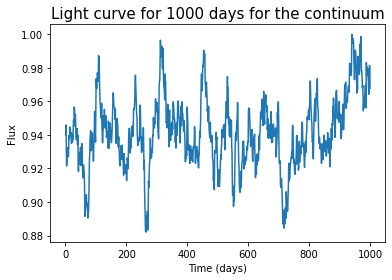

In [5]:
plt.plot(x_band[:1000]['t'], x_band[:1000]['flux'])#, err=x_band[:1000]['err'])
plt.title('Light curve for 1000 days for the continuum', fontsize=15)
plt.xlabel('Time (days)')
plt.ylabel('Flux')

In [6]:
# # Potting the LC of first 1000 days for the continuum + em. line light curve

Text(0, 0.5, 'Flux')

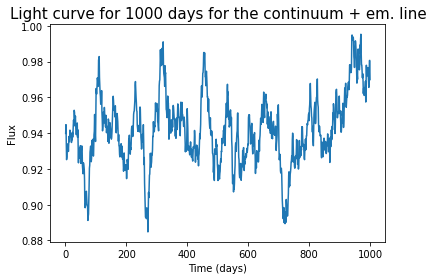

In [7]:
#plt.errorbar(y_band[:1000]['t'], y_band[:1000]['flux'], yerr=x_band[:1000]['err'])
plt.plot(y_band[:1000]['t'], y_band[:1000]['flux'])
plt.title('Light curve for 1000 days for the continuum + em. line', fontsize=15)
plt.xlabel('Time (days)')
plt.ylabel('Flux')

# Extracting and storing the first LCs for first 1000 days.

In [8]:
x_band_s=x_band[:1000]   #Slicing to 1000 data points
y_band_s=y_band[:1000]
li_res_s=line_res[:1000]

In [9]:
# Save the data
dir_path = './data/'

cut = 1000
np.savetxt(dir_path+'x_band_s',np.c_[x_band_s.t[:cut],x_band_s.flux[:cut],x_band_s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_s',np.c_[y_band_s.t[:cut],y_band_s.flux[:cut],y_band_s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

# Generating second light curve. log(L)=44

In [10]:
x_band_2,y_band_2,line_res_2=rm.lc_two_bands(T=5000.0, osc=True, A=0.14, noise=0.00005, z=0.1, method='Kelly1',
                 lag='random', lum=44, wl=0.2, wc=0.8, plot_kernel=False)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 44.00
MBH = 1.46e+07 M_sun
tau_DRW = 31.98 days
sigma_DRW = 0.03 mag^2/day
Time-lag = 33.65 days


In [11]:
x_band_2s=x_band_2[:1000]   #Slicing to 1000 data points
y_band_2s=y_band_2[:1000]
li_res_2s=line_res_2[:1000]

In [12]:
# Save the data
dir_path = './data/'

cut = 1000
np.savetxt(dir_path+'x_band_2s',np.c_[x_band_2s.t[:cut],x_band_2s.flux[:cut],x_band_2s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_2s',np.c_[y_band_2s.t[:cut],y_band_2s.flux[:cut],y_band_2s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

# Generating third light curve. log(L)=45

In [13]:
x_band_3,y_band_3,line_res_3=rm.lc_two_bands(T=5000.0, osc=True, A=0.14, noise=0.00005, z=0.1, method='Kelly1',
                 lag='random', lum=45, wl=0.2, wc=0.8, plot_kernel=False)

Properties of the simulated AGN object:
---------------------------------------
log(L) = 45.00
MBH = 6.76e+07 M_sun
tau_DRW = 59.10 days
sigma_DRW = 0.01 mag^2/day
Time-lag = 114.82 days


In [14]:
x_band_3s=x_band_3[:1000]   #Slicing to 1000 data points
y_band_3s=y_band_3[:1000]
li_res_3s=line_res_3[:1000]

In [15]:
# Save the data
dir_path = './data/'

cut = 1000
np.savetxt(dir_path+'x_band_3s',np.c_[x_band_3s.t[:cut],x_band_3s.flux[:cut],x_band_3s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'y_band_3s',np.c_[y_band_3s.t[:cut],y_band_3s.flux[:cut],y_band_3s.err[:cut]],fmt=['%.1f','%.7e','%.7e'])

# Comparison of properties

In [16]:
l=[43.0,44.0,45.0]   #log luminosity
tlag=[9.86, 33.65,114.82]   #lag in days

Text(0, 0.5, 'Time lag (days)')

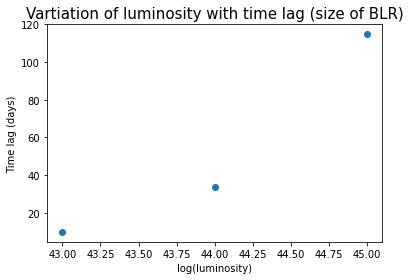

In [17]:
plt.scatter(l,tlag)
plt.title('Vartiation of luminosity with time lag (size of BLR)', fontsize=15)
plt.xlabel('log(luminosity)')
plt.ylabel('Time lag (days)')

# So for every order of rise in luminosity the size of the broad line region increases more than linearly. 

Text(0, 0.5, 'Mass of Black Hole')

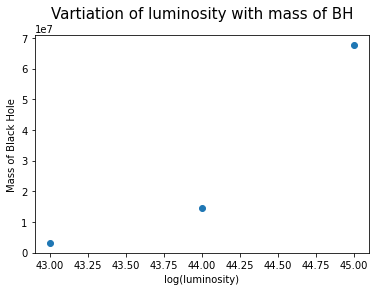

In [18]:
l= [43.0,44.0,45.0]   #log luminosity
m_bh= [3.14e+06, 1.46e+07, 6.76e+07]   #Mass of BH
plt.scatter(l,m_bh)
plt.title('Vartiation of luminosity with mass of BH', fontsize=15)
plt.xlabel('log(luminosity)')
plt.ylabel('Mass of Black Hole')

# Similarly for every order of rise in luminosity the size of the BH and the BLR increases similarly. 

# B

In [19]:
from pyzdcf import pyzdcf
#help(pyzdcf)

# For first light curve

In [20]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'x_band_s'
lc2 = 'y_band_s'

In [21]:
# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [22]:
# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



In [23]:
#acf.head()

In [24]:
#ccf.head()

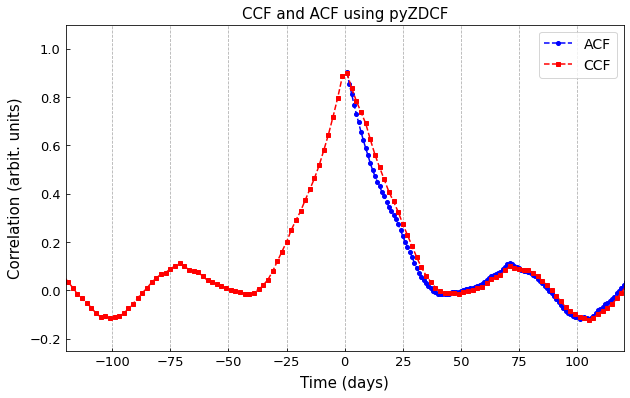

In [25]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf['tau'],acf['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf['tau'],ccf['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [26]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf = rm.add_inverted_acf(acf)

print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (1980, 7)
CCF shape:  (992, 7)


In [27]:
# We still need to make CCF and ACF the same length so we can subtract them.
# We do this by interpolating one of those functions to the time grid of the other.
acf = rm.interp(ccf,acf) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf.shape)
print('CCF shape: ',ccf.shape)

ACF shape:  (992, 7)
CCF shape:  (992, 7)


In [28]:
# Subtracting CCF and ACF
final_ccf = rm.delta_ccf(acf, ccf)

In [29]:
#final_ccf.tail()

In [30]:
# Estimate the time lag 𝜏
# We utilize the peak_finder() function from the scipy.signal package to locate the peak in 𝐶𝐶𝐹(𝜏). Errors in 𝜏 values were already estimated 
# using asymmetric error propagation (Laursen et al. 2019) when we previously called the delta_ccf() function.

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf.dcf.values,final_ccf.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf.tau == tau, '+sig(tau)'].values[0]


Peak candidates (x-axis vals):  [ 9. 95.]
Max. peak:  9.0


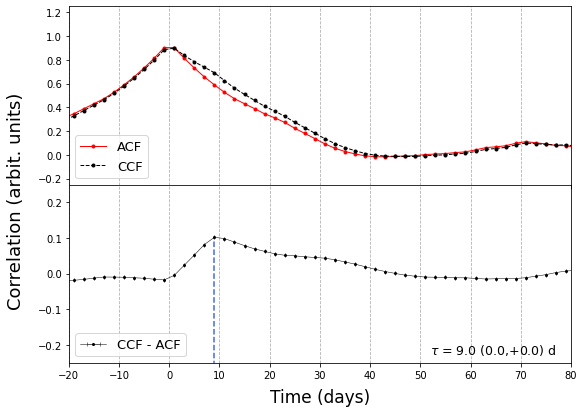

In [31]:
#lims_x = (-5,65)
#lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf,ccf,acf,locator=10,peak=True,tau=tau,err=err)#,lims_x=lims_x,lims_y=lims_y)

# The time lag is 9 days using pyZDCF
# Time lag was 9.84 days using lc_two_band

# For second light curve

In [32]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'x_band_2s'
lc2 = 'y_band_2s'

In [33]:
# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf2 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [34]:
# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf2 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



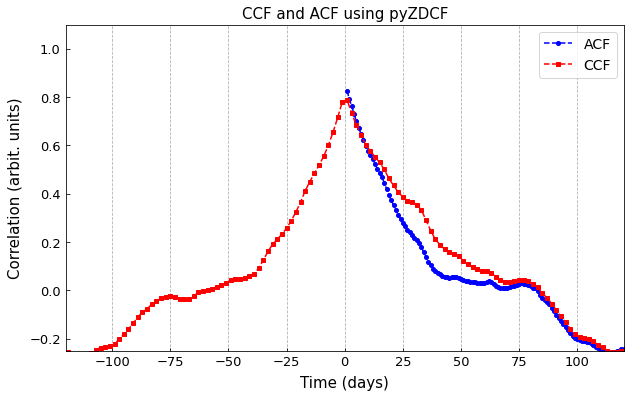

In [35]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf2['tau'],acf2['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf2['tau'],ccf2['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [36]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf2 = rm.add_inverted_acf(acf2)

print('ACF shape: ',acf2.shape)
print('CCF shape: ',ccf2.shape)

ACF shape:  (1980, 7)
CCF shape:  (992, 7)


In [37]:
# We still need to make CCF and ACF the same length so we can subtract them.
# We do this by interpolating one of those functions to the time grid of the other.
acf2 = rm.interp(ccf2,acf2) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf2.shape)
print('CCF shape: ',ccf2.shape)

ACF shape:  (992, 7)
CCF shape:  (992, 7)


In [38]:
# Subtracting CCF and ACF
final_ccf2 = rm.delta_ccf(acf2, ccf2)

In [39]:
# Estimate the time lag 𝜏
# We utilize the peak_finder() function from the scipy.signal package to locate the peak in 𝐶𝐶𝐹(𝜏). Errors in 𝜏 values were already estimated 
# using asymmetric error propagation (Laursen et al. 2019) when we previously called the delta_ccf() function.

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf2.dcf.values,final_ccf2.tau.values,(0,100))

err_low = final_ccf2.loc[final_ccf2.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf2.loc[final_ccf2.tau == tau, '+sig(tau)'].values[0]


Peak candidates (x-axis vals):  [33. 93.]
Max. peak:  33.0


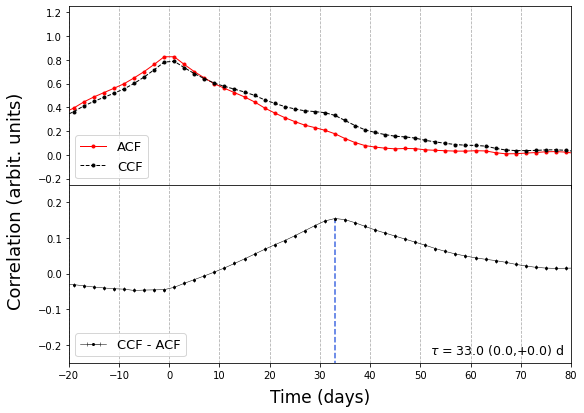

In [40]:
#lims_x = (-5,65)
#lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf2,ccf2,acf2,locator=10,peak=True,tau=tau,err=err)#,lims_x=lims_x,lims_y=lims_y)

# Time lag is 33 days.
# Time lag using lc_two_band was 33.65 days

# For the third light curve

In [41]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results


# Light curve names
lc1 = 'x_band_3s'
lc2 = 'y_band_3s'

In [42]:
# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf3 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

990 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [43]:
# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf3 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

992 bins actually used, 500032 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



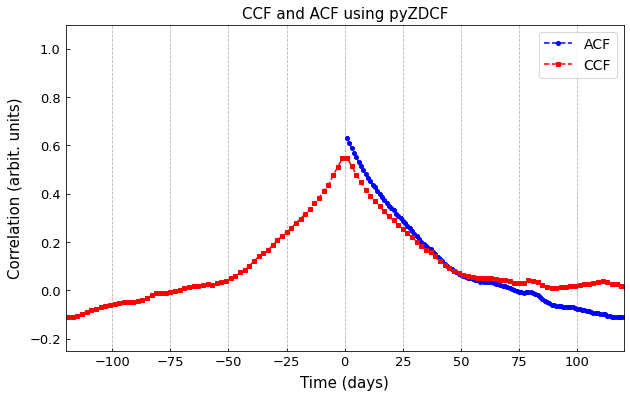

In [44]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf3['tau'],acf3['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf3['tau'],ccf3['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [45]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf3 = rm.add_inverted_acf(acf3)

print('ACF shape: ',acf3.shape)
print('CCF shape: ',ccf3.shape)

ACF shape:  (1980, 7)
CCF shape:  (992, 7)


In [46]:
# We still need to make CCF and ACF the same length so we can subtract them.
# We do this by interpolating one of those functions to the time grid of the other.
acf3 = rm.interp(ccf3,acf3) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf3.shape)
print('CCF shape: ',ccf3.shape)

ACF shape:  (992, 7)
CCF shape:  (992, 7)


In [47]:
# Subtracting CCF and ACF
final_ccf3 = rm.delta_ccf(acf3, ccf3)

In [48]:
#final_ccf3.head()

In [49]:
# Estimate the time lag 𝜏
# We utilize the peak_finder() function from the scipy.signal package to locate the peak in 𝐶𝐶𝐹(𝜏). Errors in 𝜏 values were already estimated 
# using asymmetric error propagation (Laursen et al. 2019) when we previously called the delta_ccf() function.

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf3.dcf.values,final_ccf3.tau.values,(0,200)) #Changed 100 to 1000 here

err_low = final_ccf3.loc[final_ccf3.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf3.loc[final_ccf3.tau == tau, '+sig(tau)'].values[0]


Peak candidates (x-axis vals):  [113.]
Max. peak:  113.0


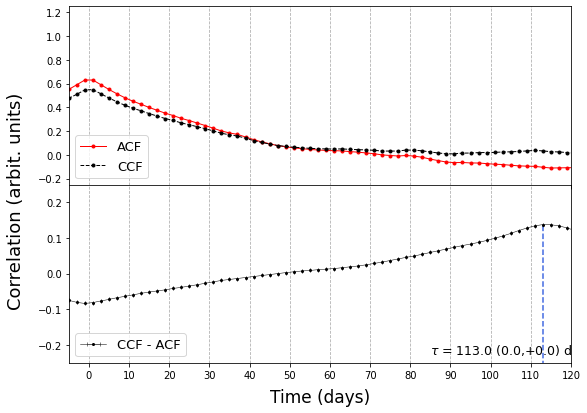

In [50]:
lims_x = (-5,120)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf3,ccf3,acf3,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x)#,lims_y=lims_y)

# The time lag is 113 days
# The time lag using lc_two_band was 114.82 days

Text(0, 0.5, 'log(luminosity)')

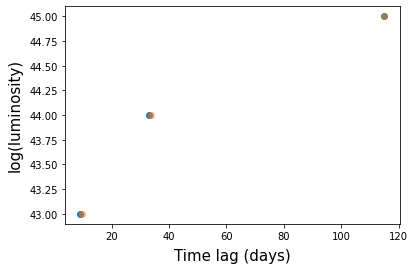

In [51]:
pyzdcf_tlag=[9.0,33.0,115.0] #These are the lags obtained from pyzdcf

plt.scatter(pyzdcf_tlag,l)
plt.scatter(tlag,l,alpha=0.5)
plt.xlabel("Time lag (days)",fontsize=15,labelpad=7)
plt.ylabel("log(luminosity)",fontsize=15,labelpad=7)

# We see here that the values of time lag obtained from pyZDCF are quite close to the ones obtained from the lc_two_bands. 

# Part C with light curve 2 where L=44

# Cadence : One observation every 5 days

In [52]:
new_x=x_band_2s[::5]  #Original 3rd LC. Not the sliced one
new_y=y_band_2s[::5]

In [53]:
# Save the data
dir_path = './data/'

np.savetxt(dir_path+'new_x',new_x.values,fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'new_y',new_y.values,fmt=['%.1f','%.7e','%.7e'])

In [54]:
# Light curve names
lc1 = 'new_x'
lc2 = 'new_y'

# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf_n1 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

190 bins actually used, 45.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.



In [55]:
# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf_n1 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

380 bins actually used, 290 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



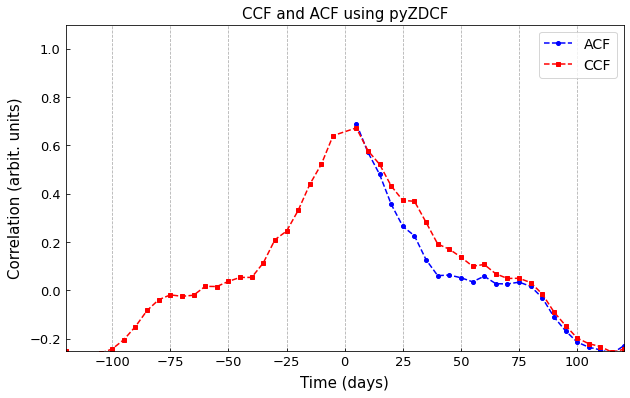

In [56]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_n1['tau'],acf_n1['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf_n1['tau'],ccf_n1['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [57]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf_n1 = rm.add_inverted_acf(acf_n1)

print('ACF shape: ',acf_n1.shape)
print('CCF shape: ',ccf_n1.shape)

ACF shape:  (380, 7)
CCF shape:  (380, 7)


In [58]:
# Subtracting CCF and ACF
final_ccf_n1 = rm.delta_ccf(acf_n1, ccf_n1)

In [59]:
# Estimate the time lag 𝜏
# We utilize the peak_finder() function from the scipy.signal package to locate the peak in 𝐶𝐶𝐹(𝜏). Errors in 𝜏 values were already estimated 
# using asymmetric error propagation (Laursen et al. 2019) when we previously called the delta_ccf() function.

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf_n1.dcf.values,final_ccf_n1.tau.values,(0,1000)) #Changed 100 to 1000 here

err_low = final_ccf_n1.loc[final_ccf_n1.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf_n1.loc[final_ccf_n1.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [ 35.  95. 160. 250. 265. 320. 375. 400. 465. 485. 495. 540. 640. 665.
 675. 715. 755. 815. 845. 870. 940.]
Max. peak:  35.0


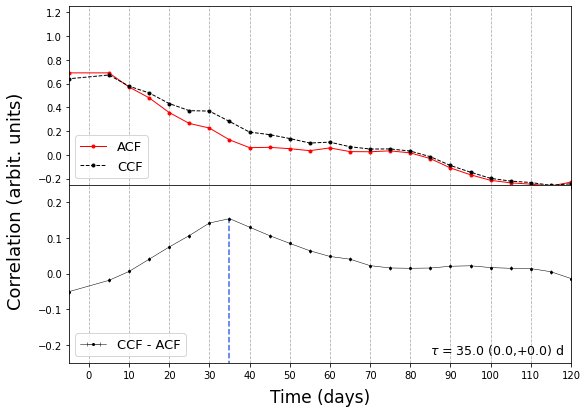

In [60]:
lims_x = (-5,120)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf_n1,ccf_n1,acf_n1,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x)#,lims_y=lims_y)

# The time lag is 35 days with a cadence of 5 days.
# This is close to the value of 33.65 days and 33.0 days obtained from lc_two_band and pyZDCF

# Cadence : one months of observations every day, then one month pause. Repeat the pattern.

In [61]:
#groupsx = [x_band_2s[i:i+30] for i in range(0, len(x_band_2s), 30)]
#groupsy = [y_band_2s[i:i+30] for i in range(0, len(x_band_2s), 30)]
# Select the first row of each group and create a new dataframe
#new_x1 = pd.concat([g.iloc[0] for g in groupsx], axis=1).T.reset_index(drop=True)
#new_y1 = pd.concat([g.iloc[0] for g in groupsy], axis=1).T.reset_index(drop=True)

mask = ((x_band_2s.index // 30) % 2 == 0)

# apply the mask to select the desired rows
new_x1 = x_band_2s.loc[mask]


mask1 = ((y_band_2s.index // 30) % 2 == 0)

new_y1 = y_band_2s.loc[mask1]

In [62]:
new_x1

,t,flux,err
0,1.0,0.958172,0.004894
1,2.0,0.962010,0.004904
2,3.0,0.955146,0.004887
3,4.0,0.955590,0.004888
4,5.0,0.954534,0.004885
...,...,...,...
985,986.0,0.975106,0.004937
986,987.0,0.977118,0.004942
987,988.0,0.981107,0.004953
988,989.0,0.972277,0.004930


In [63]:
# Save the data
dir_path = './data/'

np.savetxt(dir_path+'new_x1',new_x1.values,fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'new_y1',new_y1.values,fmt=['%.1f','%.7e','%.7e'])

In [64]:
# Light curve names
lc1 = 'new_x1'
lc2 = 'new_y1'

# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf_n2 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf_n2 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')



pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

906 bins actually used, 628.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

924 bins actually used, 130530 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



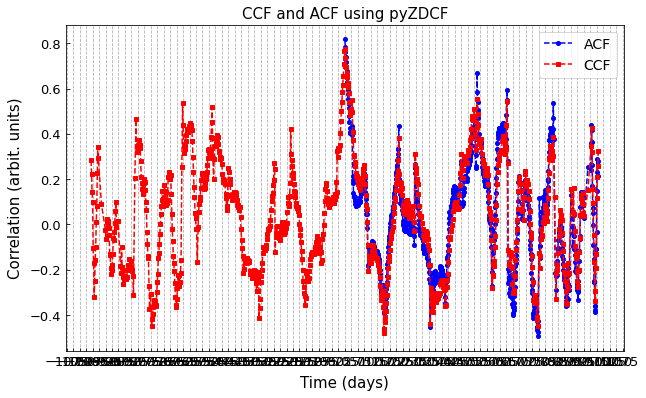

In [65]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_n2['tau'],acf_n2['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf_n2['tau'],ccf_n2['dcf'],'s--r',label='CCF',markersize=4)

#ax.set_xlim(-120,120)
#ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [66]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf_n2 = rm.add_inverted_acf(acf_n2)

print('ACF shape: ',acf_n2.shape)
print('CCF shape: ',ccf_n2.shape)

ACF shape:  (1812, 7)
CCF shape:  (924, 7)


In [67]:
# We do this by interpolating one of those functions to the time grid of the other.
acf_n2 = rm.interp(ccf_n2,acf_n2) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf_n2.shape)
print('CCF shape: ',ccf_n2.shape)

ACF shape:  (924, 7)
CCF shape:  (924, 7)


In [68]:
#acf_n2=acf_n2.fillna(0)
#acf_n2 = acf_n2.astype(int)

In [69]:
#acf_n2 =acf_n2.dropna()

In [70]:
# Subtracting CCF and ACF
final_ccf_n2 = rm.delta_ccf(acf_n2, ccf_n2)

In [71]:
# Estimate the time lag 𝜏
# We utilize the peak_finder() function from the scipy.signal package to locate the peak in 𝐶𝐶𝐹(𝜏). Errors in 𝜏 values were already estimated 
# using asymmetric error propagation (Laursen et al. 2019) when we previously called the delta_ccf() function.

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf_n2.dcf.values,final_ccf_n2.tau.values,(0,1000)) #Changed 100 to 1000 here

err_low = final_ccf_n2.loc[final_ccf_n2.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf_n2.loc[final_ccf_n2.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [ 31.          35.          83.          89.          97.
 113.         145.         153.         159.         171.
 195.         201.         207.         227.         233.
 241.         247.         259.         269.         281.
 321.         329.         339.         385.         407.
 455.         461.         493.         507.         545.
 555.         617.         639.         661.         679.
 687.         699.         705.         715.         719.
 723.         739.         747.         757.         781.
 797.         801.         811.76923077 819.         841.
 853.         867.72727273 885.         895.         913.
 917.         923.         963.         977.        ]
Max. peak:  31.0


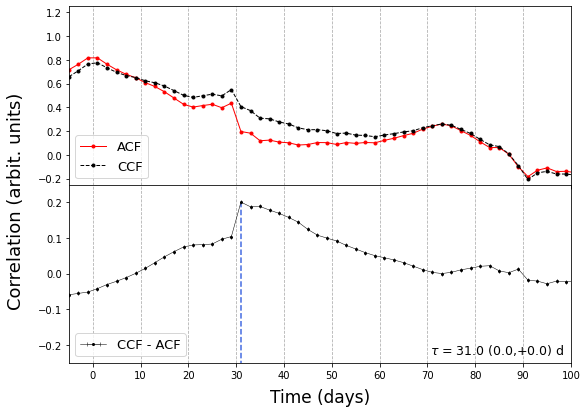

In [72]:
lims_x = (-5,100)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf_n2,ccf_n2,acf_n2,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x)#,lims_y=lims_y)

# The time lag here is 31 days as compared to 33.65 days and 33.0 days obtained from lc_two_band and pyZDCF.

# Cadence : three month of observations every day, followed by six months of observations with a frequency of once per month and then a gap of three months.Repeat the pattern.


In [73]:
# Create an empty DataFrame to store the filtered data
#new_x3 = x_band_3s.DataFrame(columns=x_band_3s.columns)
new_y3 = y_band_2s.copy()
new_y3 = new_y3.iloc[0:0] # empty the new DataFrame


# Loop through the data in chunks of 360 points
for i in range(0, len(y_band_2s), 360):
    
    # Keep the first 90 points
    new_y3 = pd.concat([new_y3, y_band_3s.iloc[i:i+90]])
    
    # Keep one point out of 30 for the next 180 points
    new_y3 = pd.concat([new_y3, y_band_3s.iloc[i+90:i+270:30]])
    
    # Drop the next 90 points
    new_y3 = pd.concat([new_y3, y_band_3s.iloc[i+270:i+360]])



In [74]:
new_y3

,t,flux,err
0,1.0,0.972579,0.005068
1,2.0,0.974620,0.005073
2,3.0,0.972614,0.005068
3,4.0,0.972591,0.005068
4,5.0,0.973667,0.005070
...,...,...,...
995,996.0,0.987460,0.005106
996,997.0,0.987518,0.005106
997,998.0,0.986820,0.005105
998,999.0,0.986535,0.005104


In [75]:
# Create an empty DataFrame to store the filtered data
#new_x3 = x_band_3s.DataFrame(columns=x_band_3s.columns)
new_x3 = x_band_2s.copy()
new_x3 = new_x3.iloc[0:0] # empty the new DataFrame


# Loop through the data in chunks of 360 points
for i in range(0, len(x_band_2s), 360):
    
    # Keep the first 90 points
    new_x3 = pd.concat([new_x3, x_band_3s.iloc[i:i+90]])
    
    # Keep one point out of 30 for the next 180 points
    new_x3 = pd.concat([new_x3, x_band_3s.iloc[i+90:i+270:30]])
    
    # Drop the next 90 points
    new_x3 = pd.concat([new_x3, x_band_3s.iloc[i+270:i+360]])



In [76]:
new_x3

,t,flux,err
0,1.0,0.972579,0.004931
1,2.0,0.975130,0.004937
2,3.0,0.972622,0.004931
3,4.0,0.972593,0.004931
4,5.0,0.973939,0.004934
...,...,...,...
995,996.0,0.987943,0.004970
996,997.0,0.988181,0.004970
997,998.0,0.987509,0.004969
998,999.0,0.987389,0.004968


In [77]:
# Save the data
dir_path = './data/'

np.savetxt(dir_path+'new_x3',new_x3.values,fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'new_y3',new_y3.values,fmt=['%.1f','%.7e','%.7e'])

In [78]:
# Light curve names
lc1 = 'new_x3'
lc2 = 'new_y3'

# ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf_n3 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


# CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf_n3 = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')



pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

855 bins actually used, 753.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

858 bins actually used, 115180 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



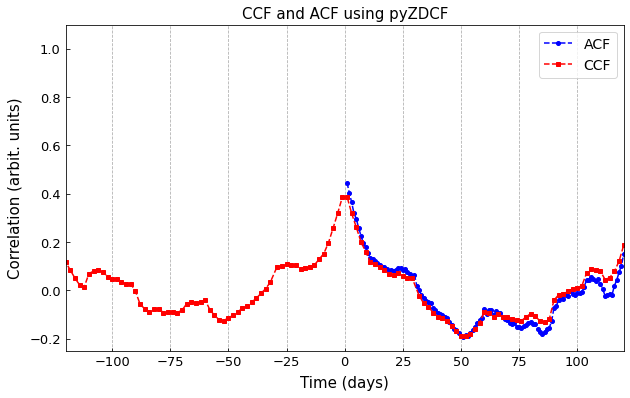

In [79]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_n3['tau'],acf_n3['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf_n3['tau'],ccf_n3['dcf'],'s--r',label='CCF',markersize=4)

ax.set_xlim(-120,120)
ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (days)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [80]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
# We obtained the 𝐶𝐶𝐹 (continuum & line) and 𝐴𝐶𝐹 (continuum) functions using pyZDCF, and will now calculate 𝐶𝐶𝐹(𝜏).
acf_n3 = rm.add_inverted_acf(acf_n3)

print('ACF shape: ',acf_n3.shape)
print('CCF shape: ',ccf_n3.shape)

ACF shape:  (1710, 7)
CCF shape:  (858, 7)


In [81]:
# We do this by interpolating one of those functions to the time grid of the other.
acf_n3 = rm.interp(ccf_n3,acf_n3) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf_n3.shape)
print('CCF shape: ',ccf_n3.shape)

ACF shape:  (858, 7)
CCF shape:  (858, 7)


In [82]:
final_ccf_n3 = rm.delta_ccf(acf_n3, ccf_n3)

In [83]:
#EStimate time lag

tau, peaks_x, peaks_y = rm.peak_finder(final_ccf_n3.dcf.values,final_ccf_n3.tau.values,(0,100))

err_low = final_ccf.loc[final_ccf_n3.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf.loc[final_ccf_n3.tau == tau, '+sig(tau)'].values[0]


Peak candidates (x-axis vals):  [15.       29.046875 50.       84.      ]
Max. peak:  84.0


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

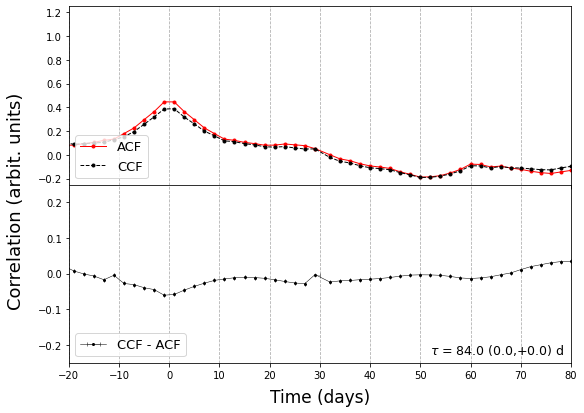

In [84]:
#lims_x = (-5,65)
#lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf_n3,ccf_n3,acf_n3,locator=10,peak=True,tau=tau,err=err)#,lims_x=lims_x,lims_y=lims_y)

# The tima lag here is 84.0 days as compared to 33.65 days and 33.0 days obtained from lc_two_band and pyZDCF.

In a previous run of the code I had obtained the lag as 29 days. 

The time lag seems to be changing with each run for data that is irregularly sampled.

# Task 2

**Goal:** Apply photometric reverberation mapping to real-world data.

Download photometric light curves of NGC 4395 from Edri et al. (2012). Choose one filter which covers the continuum emission only and the other one that covers the H$\alpha$ emission line and the underlying continuum. Using the utility functions provided, process the data so that time is expressed in hours and line intensity and its error are expressed as normalized flux. Plot the light curves. You will see that they are divided into segments because we have a pause in observations during the daylight. Choose the first segment and estimate the time lag using this data. Compare your results to Edri et al. (2012) and discuss the pros and cons of photometric reverberation mapping compared to spectroscopic reverberation mapping.

In [85]:
# Data from the paper can be downloaded from https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/756/73#/browse
# test_r/i/g has the data for the paper in r,i and g band respectively

# The 3 filters we use are r′ that includes Hα, g′ that includes Hβ,and i′ that includes mostly only continuum.

In [86]:
# Light curve processing utility function
from lc_proc import lc_proc

# The r-band has H-alpha line

In [87]:
# Read the light curves using pd.read_csv()

r_band = pd.read_csv('./data/test_r',header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2,3])

#Inserted headings in the files...MJD mag mag_err

In [88]:
r_band

,filter,MJD,mag,mag_err
0,r,2.455616e+06,16.272,0.027
1,r,2.455616e+06,16.270,0.026
2,r,2.455616e+06,16.263,0.022
3,r,2.455616e+06,16.260,0.021
4,r,2.455616e+06,16.251,0.021
...,...,...,...,...
277,r,2.455627e+06,16.305,0.021
278,r,2.455627e+06,16.319,0.023
279,r,2.455627e+06,16.301,0.023
280,r,2.455627e+06,16.305,0.023


In [89]:
lc_r = [r_band]

In [90]:
new_lc_r = lc_proc(lc_r, 'r', time='hours')
#Returns A list of input light curves with added columns: time_hours, flux, flux_err, norm_flux, norm_flux_err

In [91]:
new_lc_r

[    filter           MJD     mag  mag_err  time_hours         flux   flux_err  \
 0        r  2.455616e+06  16.272    0.027     0.00000  2577.507870  69.592712   
 1        r  2.455616e+06  16.270    0.026     0.46464  2582.260191  67.138765   
 2        r  2.455616e+06  16.263    0.022     0.69696  2598.962421  57.177173   
 3        r  2.455616e+06  16.260    0.021     0.92928  2606.153550  54.729225   
 4        r  2.455616e+06  16.251    0.021     1.16160  2627.846541  55.184777   
 ..     ...           ...     ...      ...         ...          ...        ...   
 277      r  2.455627e+06  16.305    0.021   246.94248  2500.345362  52.507253   
 278      r  2.455627e+06  16.319    0.023   247.17528  2468.311690  56.771169   
 279      r  2.455627e+06  16.301    0.023   247.40808  2509.573964  57.720201   
 280      r  2.455627e+06  16.305    0.023   247.64064  2500.345362  57.507943   
 281      r  2.455627e+06  16.297    0.024   247.87344  2518.836628  60.452079   
 
      norm_flu

In [92]:
new_lc_r[0]

,filter,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,r,2.455616e+06,16.272,0.027,0.00000,2577.507870,69.592712,0.367951,0.139859
1,r,2.455616e+06,16.270,0.026,0.46464,2582.260191,67.138765,0.377501,0.134927
2,r,2.455616e+06,16.263,0.022,0.69696,2598.962421,57.177173,0.411067,0.114907
3,r,2.455616e+06,16.260,0.021,0.92928,2606.153550,54.729225,0.425519,0.109988
4,r,2.455616e+06,16.251,0.021,1.16160,2627.846541,55.184777,0.469115,0.110903
...,...,...,...,...,...,...,...,...,...
277,r,2.455627e+06,16.305,0.021,246.94248,2500.345362,52.507253,0.212879,0.105522
278,r,2.455627e+06,16.319,0.023,247.17528,2468.311690,56.771169,0.148502,0.114092
279,r,2.455627e+06,16.301,0.023,247.40808,2509.573964,57.720201,0.231426,0.115999
280,r,2.455627e+06,16.305,0.023,247.64064,2500.345362,57.507943,0.212879,0.115572


Text(0, 0.5, 'Normalized Flux')

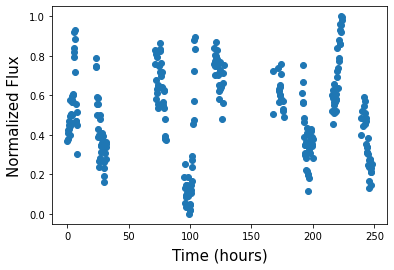

In [93]:
plt.scatter(new_lc_r[0]['time_hours'],new_lc_r[0]['norm_flux'])  #Normalized flux
plt.xlabel("Time (hours)",fontsize=15,labelpad=7)
plt.ylabel("Normalized Flux",fontsize=15,labelpad=7)

Text(0, 0.5, 'r-mag')

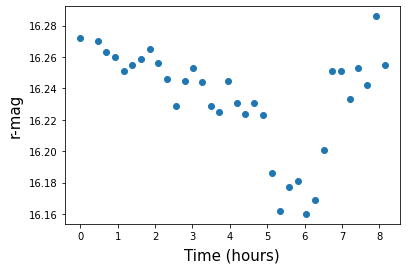

In [94]:
plt.scatter(new_lc_r[0]['time_hours'][:35],new_lc_r[0]['mag'][:35])  #flux
plt.xlabel("Time (hours)",fontsize=15,labelpad=7)
plt.ylabel("r-mag",fontsize=15,labelpad=7)

# Only first 35 points define the first segment

# The i-band includes mostly only continuum

In [95]:
i_band = pd.read_csv('./data/test_i',header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2,3])

lc_i = [i_band]#, b]
new_lc_i = lc_proc(lc_i, 'i', time='hours')


In [96]:
new_lc_i[0]

,filter,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,i,2.455616e+06,16.878,0.048,0.00000,983.558056,47.210787,0.430746,0.176837
1,i,2.455616e+06,16.928,0.035,0.23304,939.290652,32.875173,0.264934,0.123140
2,i,2.455616e+06,16.844,0.042,0.46536,1014.845663,42.623518,0.547940,0.159655
3,i,2.455616e+06,16.879,0.030,0.69744,982.652583,29.479577,0.427355,0.110421
4,i,2.455616e+06,16.863,0.024,0.93000,997.240712,23.933777,0.481997,0.089649
...,...,...,...,...,...,...,...,...,...
266,i,2.455627e+06,16.963,0.027,247.17552,909.494339,24.556347,0.153326,0.091981
267,i,2.455627e+06,16.981,0.028,247.40832,894.540484,25.047134,0.097314,0.093819
268,i,2.455627e+06,16.990,0.028,247.64112,887.156012,24.840368,0.069654,0.093044
269,i,2.455627e+06,16.975,0.031,247.87368,899.497582,27.884425,0.115881,0.104447


Text(0, 0.5, 'i-mag')

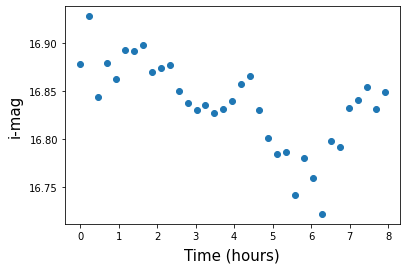

In [97]:
plt.scatter(new_lc_i[0]['time_hours'][:35],new_lc_i[0]['mag'][:35])  #flux
plt.xlabel("Time (hours)",fontsize=15,labelpad=7)
plt.ylabel("i-mag",fontsize=15,labelpad=7)

In [98]:
#Saving this data to use in pyZDCF

In [99]:
# Save only the first segment to calculate lag
dir_path = './data/'

cut = 35
np.savetxt(dir_path+'new_i',np.c_[new_lc_i[0].time_hours[:cut],new_lc_i[0].flux[:cut],new_lc_i[0].flux_err[:cut]],fmt=['%.1f','%.7e','%.7e'])
np.savetxt(dir_path+'new_r',np.c_[new_lc_r[0].time_hours[:cut],new_lc_r[0].flux[:cut],new_lc_r[0].flux_err[:cut]],fmt=['%.1f','%.7e','%.7e'])

In [100]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'new_i'
lc2 = 'new_r'

In [101]:
# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf_ri = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


# Step 3: CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf_ri = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')



pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

32 bins actually used, 47.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

60 bins actually used, 162 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



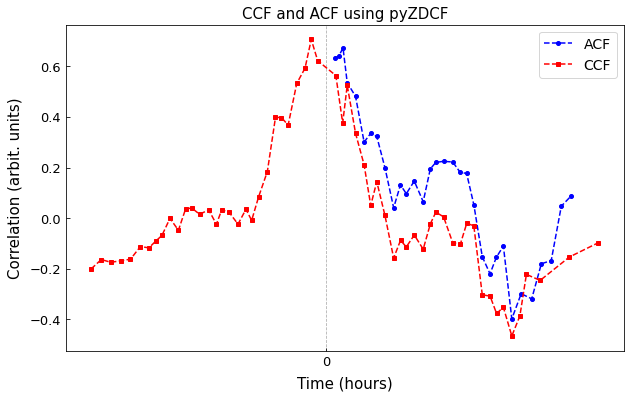

In [102]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_ri['tau'],acf_ri['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf_ri['tau'],ccf_ri['dcf'],'s--r',label='CCF',markersize=4)

#ax.set_xlim(-120,120)
#ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (hours)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [103]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf_ri = rm.add_inverted_acf(acf_ri)

print('ACF shape: ',acf_ri.shape)
print('CCF shape: ',ccf_ri.shape)

ACF shape:  (64, 7)
CCF shape:  (60, 7)


In [104]:
# We do this by interpolating one of those functions to the time grid of the other.
acf_ri = rm.interp(ccf_ri,acf_ri) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf_ri.shape)
print('CCF shape: ',ccf_ri.shape)

ACF shape:  (60, 7)
CCF shape:  (60, 7)


In [105]:
# Subtracting CCF and ACF
final_ccf_ri = rm.delta_ccf(acf_ri, ccf_ri)

In [106]:
tau, peaks_x, peaks_y = rm.peak_finder(final_ccf_ri.dcf.values,final_ccf_ri.tau.values,(0,100))

err_low = final_ccf_ri.loc[final_ccf_ri.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf_ri.loc[final_ccf_ri.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [0.5        0.89999998 1.20000005 1.89999998 2.29999995 2.5999999
 3.5        3.88461546 4.4000001  4.74545453]
Max. peak:  4.745454528115013


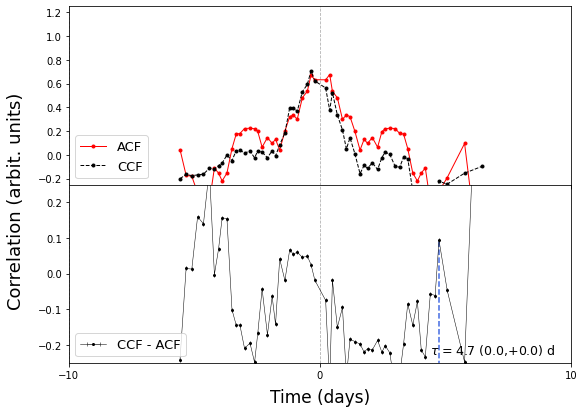

In [107]:
lims_x = (-10,10)
#lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf_ri,ccf_ri,acf_ri,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x)#,lims_y=lims_y)

# The lag here is 4.7 hours as compared to 3.6 ± 0.8 hours given in Edri et al. (2012)

# Testing with g' and i' band

In [108]:
g_band = pd.read_csv('./data/test_g',header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2,3]) # Has H beta line. 

In [109]:
g_band

,filter,MJD,mag,mag_err
0,g,2.455616e+06,17.289,0.019
1,g,2.455616e+06,17.264,0.022
2,g,2.455616e+06,17.274,0.015
3,g,2.455616e+06,17.261,0.019
4,g,2.455616e+06,17.258,0.015
...,...,...,...,...
265,g,2.455627e+06,17.336,0.022
266,g,2.455627e+06,17.342,0.020
267,g,2.455627e+06,17.325,0.023
268,g,2.455627e+06,17.298,0.023


In [110]:
lc_g = [g_band]
new_lc_g = lc_proc(lc_g, 'g', time='hours')

Text(0, 0.5, 'g-mag')

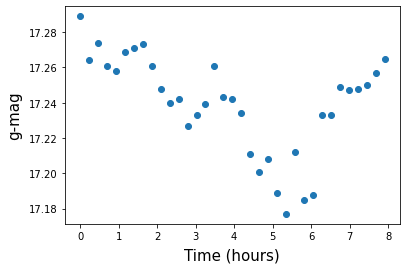

In [111]:
plt.scatter(new_lc_g[0]['time_hours'][:35],new_lc_g[0]['mag'][:35])  #flux
plt.xlabel("Time (hours)",fontsize=15,labelpad=7)
plt.ylabel("g-mag",fontsize=15,labelpad=7)

In [112]:
# Save only the first segment to calculate lag
dir_path = './data/'

cut = 35

np.savetxt(dir_path+'new_g',np.c_[new_lc_g[0].time_hours[:cut],new_lc_g[0].flux[:cut],new_lc_g[0].flux_err[:cut]],fmt=['%.1f','%.7e','%.7e'])

In [113]:
# Set input parameters for pyZDCF
input_dir = './data/'     # Path to the input light curve data
output_dir = './results/' # Path to the directory for saving the results

# Light curve names
lc1 = 'new_i'
lc2 = 'new_g'


# Step 2: ACF calculation

# Parameters are passed to pyzdcf as a dictionary
params = dict(autocf            =  True,  # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'acf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1    # Name of the light curve file
             )

# Run pyzdcf
acf_gi = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')


# Step 3: CCF calculation
params = dict(autocf            =  False, # Autocorrelation (True) or cross-correlation (False)
              prefix            = 'ccf',  # Output files prefix
              uniform_sampling  =  False, # Uniform sampling?
              omit_zero_lags    =  True,  # Omit zero lag points?
              minpts            =  0,     # Min. num. of points per bin (0 is a flag for default value of 11)
              num_MC            =  100,   # Num. of Monte Carlo simulations for error estimation
              lc1_name          =  lc1,   # Name of the first light curve file
              lc2_name          =  lc2    # Name of the second light curve file
             )

ccf_gi = pyzdcf(input_dir,output_dir,intr=False,parameters=params,sep=' ',sparse='auto')



pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   True
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

32 bins actually used, 47.0 inter-dependent pairs discarded.


acf.dcf written...

pyZDCF ended.


pyZDCF begins:

pyZDCF PARAMETERS:

Autocorrelation?   False
Uniform sampling?  False
Omit zero lags?    True
Minimal # in bin:  11
# of Monte Carlo:  100
Monte Carlo seed:  123456

Binning with minimum of 11 points per bin and resolution of 0.001

64 bins actually used, 129 inter-dependent pairs discarded.


ccf.dcf written...

pyZDCF ended.



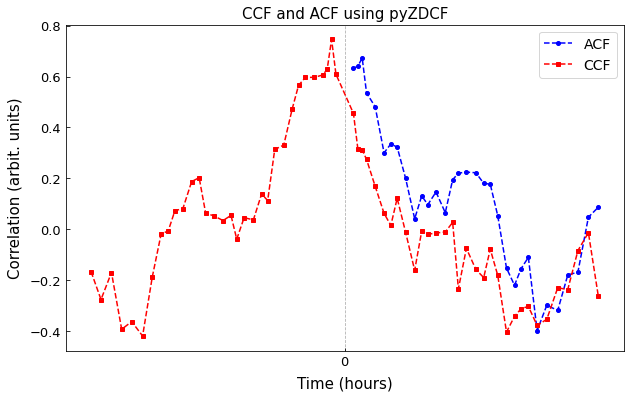

In [114]:
# Plot CCF and ACF
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(acf_gi['tau'],acf_gi['dcf'],'o--b',label='ACF',markersize=4)
ax.plot(ccf_gi['tau'],ccf_gi['dcf'],'s--r',label='CCF',markersize=4)

#ax.set_xlim(-120,120)
#ax.set_ylim(-0.25,1.1)
ax.set_xlabel("Time (hours)",fontsize=15,labelpad=7)
ax.set_ylabel("Correlation (arbit. units)",fontsize=15,labelpad=7)
ax.legend(fontsize=14)
loc = plticker.MultipleLocator(25)
ax.xaxis.set_major_locator(loc)
ax.tick_params(direction='in', pad = 5,labelsize=13)
ax.set_title('CCF and ACF using pyZDCF',fontsize=15)
ax.grid(which='major',axis='x',linestyle='--')
plt.show()

In [115]:
# Since pyZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf_gi = rm.add_inverted_acf(acf_gi)

print('ACF shape: ',acf_gi.shape)
print('CCF shape: ',ccf_gi.shape)

ACF shape:  (64, 7)
CCF shape:  (64, 7)


In [116]:
# We do this by interpolating one of those functions to the time grid of the other.
acf_gi = rm.interp(ccf_gi,acf_gi) # first param is the function having the x-axis on which we want to interpolate the other function.
print('ACF shape: ',acf_gi.shape)
print('CCF shape: ',ccf_gi.shape)

ACF shape:  (64, 7)
CCF shape:  (64, 7)


In [117]:
# Subtracting CCF and ACF
final_ccf_gi = rm.delta_ccf(acf_gi, ccf_gi)

In [118]:
tau, peaks_x, peaks_y = rm.peak_finder(final_ccf_gi.dcf.values,final_ccf_gi.tau.values,(0,100))

err_low = final_ccf_gi.loc[final_ccf_gi.tau == tau, '-sig(tau)'].values[0]
err_high = final_ccf_gi.loc[final_ccf_gi.tau == tau, '+sig(tau)'].values[0]

Peak candidates (x-axis vals):  [0.5        0.89999998 1.20000005 1.89999998 2.29999995 2.78260866
 3.5        3.8833334  4.4000001  4.87142869 5.33333349]
Max. peak:  4.871428694043841


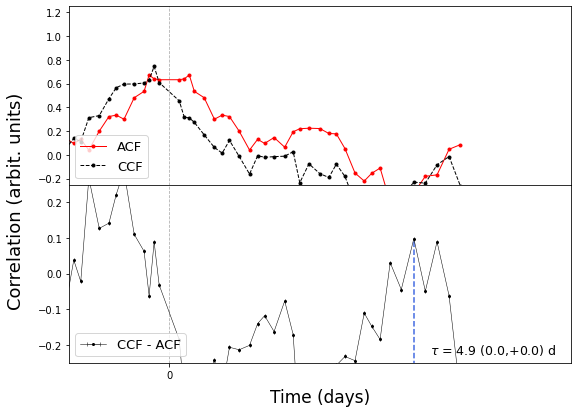

In [119]:
lims_x = (-2,8)
#lims_y = (-0.5,1)
err = (err_low*(-1), err_high)

rm.plot_ccf_acf(final_ccf_gi,ccf_gi,acf_gi,locator=10,peak=True,tau=tau,err=err,lims_x=lims_x)#,lims_y=lims_y)



# Doubt

Here I get a time lag of 4.9 days using i' band and g' band. I should not get this because the g' band has a very low strength of H beta line. 

I don't know how I get this result. 

# References:

- Edri et al. (2012) https://ui.adsabs.harvard.edu/abs/2012ApJ...756...73E/abstract
- Jankov et al. (2022) https://ui.adsabs.harvard.edu/abs/2022AN....34310090J/abstract
- Kovacevic et al. (2021) https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5012K/abstract
- [Astro Data Lab](https://datalab.noirlab.edu/)
- [pyzdcf documentation](https://pyzdcf.readthedocs.io/en/latest/?badge=latest)
- [PLIKE download link](https://www.weizmann.ac.il/particle/tal/research-activities/software)